In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler,RobustScaler
import scipy
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_validate
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import GridSearchCV
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import matplotlib.style as style
from sklearn.model_selection import train_test_split


In [2]:
pd.options.display.max_columns = 99

In [3]:
df = pd.read_csv('clean.csv')

In [4]:
df.drop(columns=['id'], inplace=True)

In [5]:
df

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,review_scores_rating,zipcode,bedrooms,beds,wifi,kitchen,AC,TV,Washer,Dryer,PetsFriendly,Parking,EssentialAdmenities,Description_Len
0,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,t,t,f,40.696524,-73.991617,100.0,11201,1.0,1.0,True,True,True,False,False,False,False,False,True,211
1,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,t,f,t,40.766115,-73.989040,93.0,10019,3.0,3.0,True,True,True,False,True,True,False,False,True,1000
2,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,t,t,t,40.808110,-73.943756,92.0,10027,1.0,3.0,True,True,True,True,False,False,False,False,True,1000
3,6.620073,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,t,t,f,37.772004,-122.431619,NaN,94117.0,2.0,2.0,True,True,False,True,True,True,False,False,True,468
4,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,t,t,t,38.925627,-77.034596,40.0,20009,0.0,1.0,True,True,True,True,False,False,False,False,True,699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74106,4.605170,Apartment,Private room,1,1.0,Real Bed,flexible,False,NYC,t,t,f,40.709025,-73.939405,NaN,11206.0,1.0,1.0,False,False,False,False,False,False,False,False,False,25
74107,5.043425,Apartment,Entire home/apt,4,2.0,Real Bed,moderate,True,LA,t,f,f,33.871549,-118.396053,93.0,90254,2.0,4.0,True,True,False,True,True,True,False,True,True,302
74108,5.220356,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,t,t,t,40.706749,-73.942377,94.0,11206.0,2.0,2.0,True,True,True,True,True,True,False,False,True,1000
74109,5.273000,Apartment,Entire home/apt,2,1.0,Real Bed,strict,True,NYC,t,f,t,40.738535,-74.000157,NaN,10011,0.0,2.0,True,True,True,True,True,True,False,False,True,555


In [7]:
Train, Test = train_test_split(df, test_size=0.80)
train, val = train_test_split(Train, test_size=0.20)

# EDA
---

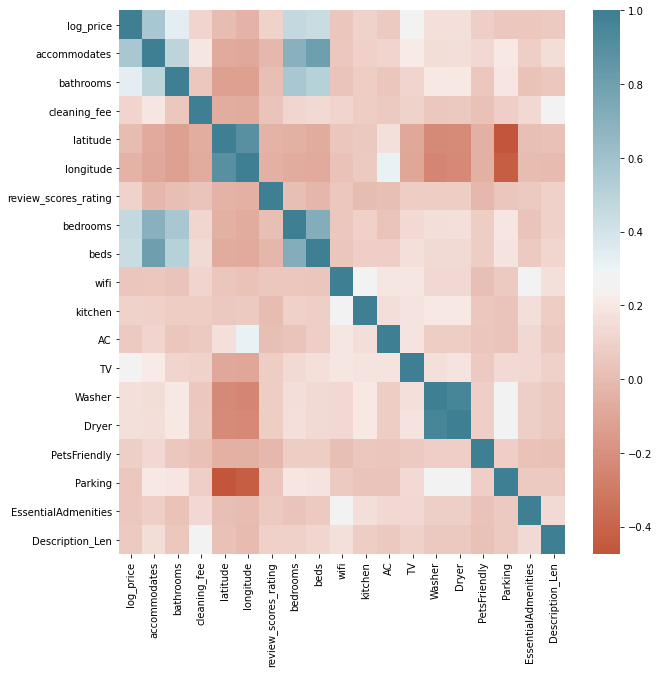

In [8]:
corr = Train.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap=sns.diverging_palette(20, 220, n=200))
plt.show()

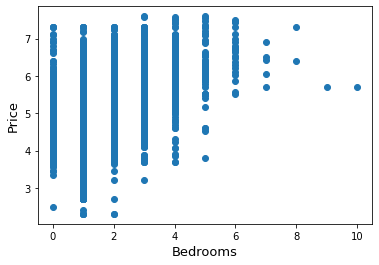

In [9]:
fig, ax = plt.subplots()
ax.scatter(x = Train['bedrooms'], y = Train['log_price'])
plt.ylabel('Price', fontsize=13)
plt.xlabel('Bedrooms', fontsize=13)
plt.show()

In [10]:
def target_analysis(target):
    fig = plt.figure(constrained_layout=True, figsize=(14,10))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(target,norm_hist=True,ax=ax1)
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Q-Q Plot')
    stats.probplot(target,plot=ax2)
    ax3 = fig.add_subplot(grid[:,2])
    ax3.set_title('Box Plot')
    sns.boxplot(target,orient='v',ax=ax3)
    print(f'skweness is { target.skew()}')
    plt.show()

skweness is 0.4891810612967403


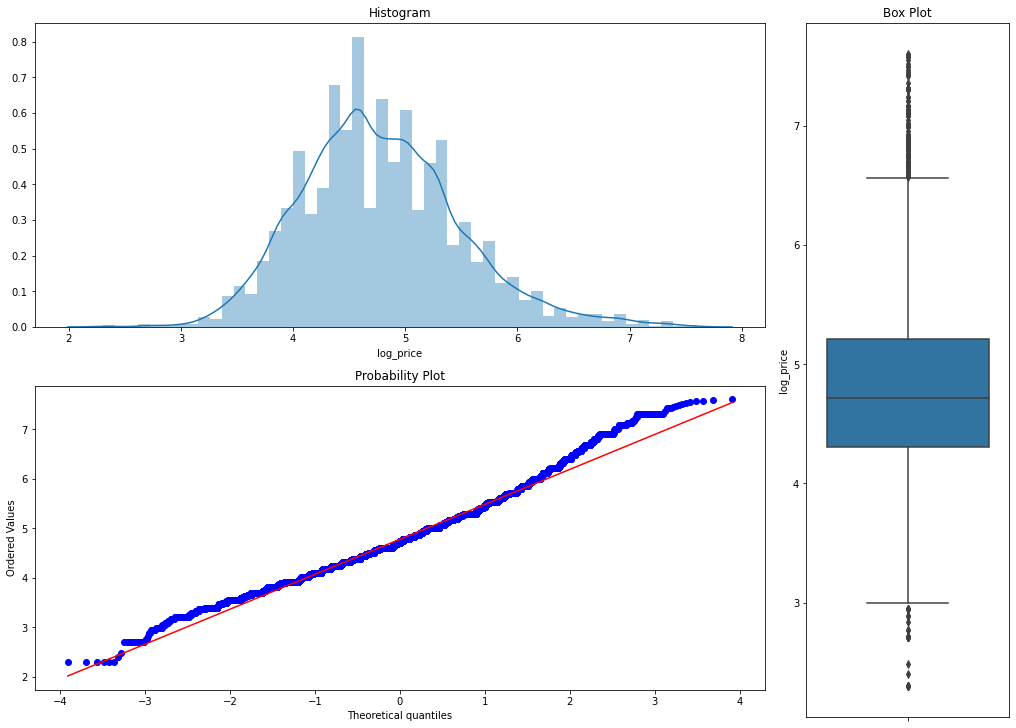

In [11]:
target_analysis(Train['log_price'])

# Feature Selection
---

In [12]:
list(train.columns)

['log_price',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bed_type',
 'cancellation_policy',
 'cleaning_fee',
 'city',
 'host_has_profile_pic',
 'host_identity_verified',
 'instant_bookable',
 'latitude',
 'longitude',
 'review_scores_rating',
 'zipcode',
 'bedrooms',
 'beds',
 'wifi',
 'kitchen',
 'AC',
 'TV',
 'Washer',
 'Dryer',
 'PetsFriendly',
 'Parking',
 'EssentialAdmenities',
 'Description_Len']

In [33]:
feature = ['property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'cleaning_fee',
 'city',
 'latitude',
 'longitude',
 'review_scores_rating',
 'zipcode',
 'bedrooms',
 'beds',
 'Dryer',
 'Parking',
 'Description_Len']
target = 'log_price'
X_train = train[feature]
X_test = val[feature]
Y_test = val[target]
Y_train = train[target]

In [34]:
X_train

,property_type,room_type,accommodates,bathrooms,cleaning_fee,city,latitude,longitude,review_scores_rating,zipcode,bedrooms,beds,Dryer,Parking,Description_Len
60244,Loft,Private room,2,1.0,True,LA,34.074666,-118.324495,91.0,90004,1.0,1.0,False,False,1000
69211,Apartment,Entire home/apt,6,1.0,False,NYC,40.723571,-73.987965,NaN,10003.0,3.0,3.0,False,False,809
29829,Apartment,Entire home/apt,3,1.0,True,NYC,40.809949,-73.944854,98.0,10027,1.0,1.0,False,False,541
65707,Apartment,Private room,4,1.0,True,NYC,40.731562,-73.955356,100.0,11222,1.0,1.0,False,True,593
52600,Apartment,Entire home/apt,2,1.0,False,NYC,40.700135,-73.927047,NaN,11237,1.0,1.0,False,False,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65476,Apartment,Entire home/apt,3,1.0,False,NYC,40.817810,-73.961190,100.0,10027,0.0,2.0,True,False,409
194,Condominium,Entire home/apt,3,1.0,False,Boston,42.382883,-71.067843,100.0,02129,2.0,2.0,True,False,275
42231,House,Private room,4,1.0,True,LA,34.030361,-118.756899,96.0,90265,1.0,1.0,True,True,581
55401,House,Private room,1,1.0,True,Boston,42.328867,-71.109745,99.0,02120,1.0,1.0,False,True,1000


# Establishing Baseline
---

In [35]:
# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = Y_train.mean()

Mean Baseline (using 0 features)


In [36]:
# Train Error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(Y_train)
predictions = np.expm1(y_pred)
mae = mean_absolute_error(np.expm1(Y_train), predictions)
print(f'Train Error: ${mae:.2f}')


Train Error: $85.86


In [37]:
# Validation Error
y_pred = [guess] * len(Y_test)
predictions = np.expm1(y_pred)
mae = mean_absolute_error(Y_test, predictions)
print(f'Validation Error: ${mae:.2f}')

Validation Error: $113.24


In [38]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import category_encoders as ce
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import KNNImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from random import randint
pipeline = make_pipeline(
    ce.BinaryEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    XGBRegressor(random_state=42,n_jobs=-1)
)
param_distributions = {     
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__learning_rate': [.03, 0.05, .07 ,0.13,0.2],
    'xgbregressor__max_depth': [5, 6, 7],}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, Y_train);

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    8.7s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:   10.1s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:   11.0s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.7s finished


In [39]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
pipeline = search.best_estimator_
y_pred = pipeline.predict(X_test)
predictions = np.expm1(y_pred)
predictions
mae = mean_absolute_error(Y_test, predictions)
print(f'Test MAE: ${mae:,.0f}')

Best hyperparameters {'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.13, 'simpleimputer__strategy': 'mean'}
Cross-validation MAE 0.2929770308153314
Test MAE: $136


In [40]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(pipeline,
                            X_test,
                            Y_test,
                            random_state=42,
                            n_jobs=-1)

p_importance = pd.DataFrame({'feature' : X_test.columns,
                             'weight'  : pi.importances_mean,
                             'std'     : pi.importances_std})

p_importance.sort_values('weight', ascending=False).tail(30)

,feature,weight,std
1,room_type,0.347214,0.008809
7,longitude,0.197628,0.004700
6,latitude,0.140282,0.005120
2,accommodates,0.114601,0.004251
3,bathrooms,0.054129,0.004363
10,bedrooms,0.039500,0.002975
8,review_scores_rating,0.037640,0.002143
5,city,0.029364,0.001701
0,property_type,0.006603,0.001168
14,Description_Len,0.005709,0.000806


In [42]:
import joblib
joblib.dump(pipeline, 'prediction.pkl')

['prediction.pkl']

In [43]:
y_pred = pipeline.predict(X_test)
predictions = np.expm1(y_pred)
predictions

array([205.25574, 138.0864 ,  67.77247, ..., 460.24606, 128.83876,
       233.928  ], dtype=float32)

In [55]:
testing_df = X_test[:1]
testing_df

,property_type,room_type,accommodates,bathrooms,cleaning_fee,city,latitude,longitude,review_scores_rating,zipcode,bedrooms,beds,Dryer,Parking,Description_Len
20195,House,Entire home/apt,3,1.0,True,LA,34.044783,-118.542195,96.0,90272,1.0,1.0,True,True,1000


In [60]:
y_pred = pipeline.predict(testing_df)
predictions = np.expm1(y_pred)
predictions[0]

205.25574

In [57]:
testing_df.to_csv('sample_pred.csv',index=False)

In [13]:
import pandas as pd
import joblib
import pickle
test_model_data = pd.read_csv('sample_pred.csv')
model = joblib.load('prediction.pkl')
response  = round(model.predict(test_model_data)[0],2)

In [12]:
round(response,2)

5.39

In [26]:
import pandas as pd
import joblib
import pickle
import json
test_model_data = pd.read_csv('sample_pred.csv')
model = joblib.load('prediction.pkl')
response  = round(model.predict(test_model_data)[0],2)
price_list = ['Prices']
response_list = [f'{round(response,2)}']
response_dict = dict(zip(price_list, response_list))
response_json = json.dumps(response_dict)
response_json

'{"Prices": "5.389999866485596"}'

In [22]:
response

5.39

In [21]:
{
  "property_type": "string",
  "room_type": "string",
  "accomodates": 0,
  "bathrooms": 0,
  "clean_fee": true,
  "city": "string",
  "latitude": 0,
  "longitude": 0,
  "review_scores_rating": 0,
  "zipcode": 0,
  "bedrooms": 0,
  "beds": 0,
  "Dryer": true,
  "Parking": true,
  "Description_Len": 0
}

NameError: name 'true' is not defined

In [27]:
list(test_model_data.columns)

['property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'cleaning_fee',
 'city',
 'latitude',
 'longitude',
 'review_scores_rating',
 'zipcode',
 'bedrooms',
 'beds',
 'Dryer',
 'Parking',
 'Description_Len']